# Markov Chain Monte Carlo with `zeus`

In this notebook we run a MCMC using the ensemble slice sampling code [zeus](https://zeus-mcmc.readthedocs.io/en/latest/index.html). The posterior resulting from this MCMC will be considered the truth and compared to the simulation based inference methods in this repo.

In this example we will:
1. Generate some simulated data.
2. Run an MCMC to infer the parameters of a model based on this data.
3. Run some simple convergence tests on the chains coming from the MCMC.

**This is a modified version of the example on the `zeus` documentation. It can be found [here](https://zeus-mcmc.readthedocs.io/en/latest/notebooks/datafit.html).**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zeus
from scipy.optimize import minimize
import corner

In [2]:
np.random.seed(100) # We set the random seed for numpy so we get the
                    # same synthetic data each time the notebook is run.

## 1. Generating some data

We start by defining our model. In this simple example our model is a straight line.

$$f(x, \theta) = m x + c$$

In [3]:
def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

Next we define what our 'true' parameters, `m_true` and `c_true`, will be. We also make some choices about what form our data will take, such as the number of data points `num_points` and the level of uncertainty `sigma` on these points.

In [4]:
m_true = 3.5 
c_true = 1.2 

num_points = 70
x = np.linspace(0, 10, num_points)

sigma = 3.0

Finally we generate our data.

$$f_o \sim \mathcal{N}(f(\theta_o), \sigma)$$

In [5]:
data = np.random.normal(loc=straight_line(x, m_true, c_true), scale=sigma)

We can plot our simulated data along with the underlying model that was used to generate it.

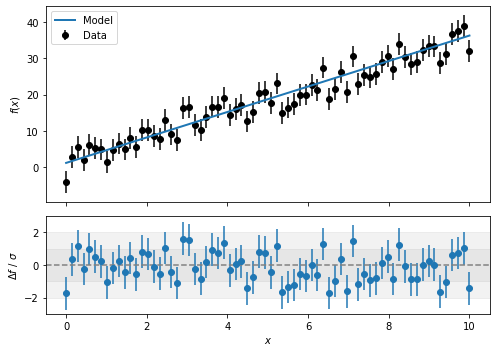

In [6]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

ax[0].errorbar(x, data, yerr=sigma, fmt="o", color='k', zorder=1, label='Data')
ax[0].plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='Model')
ax[0].legend()
ax[0].set_ylabel(r'$f(x)$')

ax[1].errorbar(x, (data-straight_line(x, m_true, c_true))/sigma, yerr=1., fmt="o")
ax[1].axhline(0., linestyle='--', color='grey')
ax[1].axhspan(-1,1, alpha=0.1, color='grey')
ax[1].axhspan(-2,2, alpha=0.1, color='grey')
ax[1].set_ylim(-3,3)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$\Delta f \ / \ \sigma$')

plt.tight_layout()
plt.show()

## Running an MCMC

To run our MCMC we need to define a function for the probability $P(\theta | f_o) \propto P(\theta)P(f_o | \theta)$. In practice we work with the logarithm of the probability $\ln{P(\theta | f_o)} \propto \ln{P(\theta)} + \ln{P(f_o | \theta)}$.

We start with the log-prior $\ln{P(\theta)}$. Our prior takes the form of a uniform prior on the intercept $c \sim \mathcal{U}(-10,10)$ and a normal prior on the gradient $m \sim \mathcal{N}(3, 10)$.

In [7]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 3.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

Next we define the log-likelihood. Our likelihood has the form of a Gaussian.

$$\ln{P(f_o | \theta)} \propto \exp{\left[-\frac{(f(\theta) - f_o)^2}{2\sigma^2}\right]}$$

In [8]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    m, c = theta

    # evaluate the model
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data)/sigma)**2)

We then simply sum the log-prior and log-likelihood to obtain the log-probability.

In [9]:
def logpost(theta, data, sigma, x):
    '''The natural logarithm of the posterior.'''

    return logprior(theta) + loglike(theta, data, sigma, x)

`zeus` is based on ensemble sampling. This means that we run an ensemble of chains (walkers) simultaneously. New proposal steps for each chain are based on the distribution of the ensemble. For full details see Karamanis, Beutler, and Peacock (2021).

Before running our MCMC we need to define the starting positions for each of the walkers. To do this we generate some draws from our prior.

In [10]:
num_walkers = 10

random_m = np.random.normal(loc=3, scale=10, size=(num_walkers, ))
random_c = np.random.uniform(-10,10, size=(num_walkers, ))

init_pos = np.vstack([random_m, random_c]).T

Finally we setup some callbacks that allow us to monitor the chain. `cb0` makes sure we have run for at least 1000 steps. `cb1` produces an estimate for integrated autocorrelation time $\tau$ every 100 steps. Once our chain has run for $50\tau$ and our estimate for $\tau$ has changed by less that 1% it will terminate.

In [11]:
cb0 = zeus.callbacks.MinIterCallback(nmin=1000)
cb1 = zeus.callbacks.AutocorrelationCallback(ncheck=100, dact=0.01, nact=50, discard=0.5)

Now we run our MCMC!

In [12]:
max_steps = 50000 # The maximum number of steps to run the MCMC.
num_dim = 2 # The number of dimensions of our problem.

sampler = zeus.EnsembleSampler(num_walkers, num_dim, logpost, args=[data, sigma, x])
sampler.run_mcmc(init_pos, max_steps, callbacks=[cb0, cb1])

Initialising ensemble of 10 walkers...
Sampling progress :   3%|█▋                                                  | 1600/50000 [00:03<01:51, 435.55it/s]


## Convergence tests and results

We start by examining $\tau$. We plot how it changes as a function of the number steps.

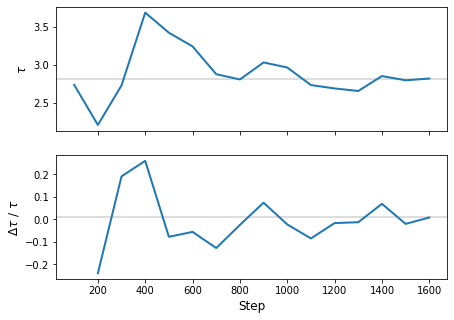

In [13]:
tau = cb1.estimates
step = np.arange(1, 1+len(tau)) * 100

fig, ax = plt.subplots(2,1, sharex=True, figsize=(7,5))

ax[0].axhline(tau[-1], color='lightgrey')
ax[0].plot(step, tau, lw=2)
ax[0].set_ylabel(r"$\tau$", fontsize='large')

ax[1].axhline(0.01, color='lightgrey')
ax[1].plot(step[1:], np.diff(tau)/tau[1:], lw=2)
ax[1].set_ylabel(r"$\Delta \tau \ / \ \tau$", fontsize='large')
ax[1].set_xlabel("Step", fontsize='large')

plt.show()

We can see from the plot above that in the early steps of the chain there is a lot of change in the estimate of $\tau$. This illustrates why we have the joint condition on when to terminate the chain.

Next we extract the chains from the sampler. These chains will be held in a numpy array of shape `(num_step, num_walkers, num_dim)`.

In [14]:
chains = sampler.get_chain()
chains.shape

(1600, 10, 2)

We can plot the chains as function of step number to examine how they evolve. Each coloured line is a differnt chain in the ensemble. We only plot the first 1/4 of the chains. For reference we plot the values of the true parameters as solid black lines, we also plot $10\tau$ as the dotted verticle line.

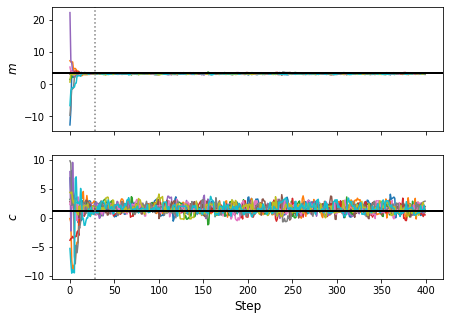

In [15]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(7,5))

for i, (val1, val2) in enumerate(zip([m_true, c_true], [r'$m$', r'$c$'])):
    ax[i].plot(chains[:int(chains.shape[0]/4),:,i])
    ax[i].axhline(val1, color='k', lw=2)
    ax[i].axvline(int(10*tau[-1]), color='grey', linestyle=':')
    ax[i].set_ylabel(val2, fontsize='large')

ax[1].set_xlabel("Step", fontsize='large')
    
plt.show()

We can see from the plots above that during the first $\sim25$ steps of the chains there is a lot of variation. The walkers are making very big steps. We can see that for $>10\tau$ steps there is less evolution in the chains. There is just random fluctuation around the truth.

We concatinate the chains, discarding this burn-in period of high variation, and save the samples to be compared to the simulation based-inference methods.

In [16]:
np.save("MCMC_samples", sampler.get_chain(flat=True, discard=int(10*tau[-1])))